In [ ]:


# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# prompt: list content of folder

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/Speciale/
%ls Data



Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Speciale
CombinedData_Arm_rs1.npy           CombinedData_Hand_s2s3s5s6s7s8.npy  Data2Save_Arm_random.npy
CombinedData_Arm_s2s3s5s6s7.npy    CombinedData_Hand_s8.npy            Data2Save_Head_random.npy
CombinedData_Arm_s2s3s5s6s7s8.npy  CombinedData_Head_rs1.npy           Data2SaveSub18Head.npy
CombinedData_Arm_s8.npy            CombinedData_Head_s2s3s5s6s7.npy    HighPass/
CombinedData_Hand_rs1.npy          CombinedData_Head_s2s3s5s6s7s8.npy
CombinedData_Hand_s2s3s5s6s7.npy   CombinedData_Head_s8.npy


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
from enum import Enum



In [ ]:

name1 = "CombinedData_Arm_s2s3s5s6s7"
name1 = "CombinedData_Arm_s8"
name2 = "CombinedData_Hand_s2s3s5s6s7"
name2 = "CombinedData_Hand_s8"
name3 = "CombinedData_Head_s8"
name3 = "CombinedData_Head_s2s3s5s6s7"
name3 = "CombinedData_Head_rs1"

subjectName = "forsøgsperson s2s3s5s6s7"
subjectName = "tilfældig 9. forsøgsperson"
dataType = "Hånd"
dataType = "Øre"

plottext = f"{subjectName} - {dataType}"
raw_orgs = []
label_orgs = []
TrainedOn= ""
# for name in [name1,name2,name3]:
for name in [name3]:
  TrainedOn = "CombinedData_Head_s2s3s5s6s7"

  with open('Data/HighPass/'+name+'.npy', 'rb') as f:
      raw_org = np.load(f)
      label_org = np.load(f)

  # print(raw_org.shape)
  # print(label_org.shape)
  timeline_s = raw_org[:,-1]
  raw_org = raw_org[:,:-1] #Remove time axis          [x1,y1,z1,x2,y2,z2,meg1,meg2]
  label_org = label_org[:,0] #Keep only movement axis [movement;lejring;Timeline_s]

  print("______________")
  print(name)
  print(raw_org.shape)
  print(label_org.shape)
  raw_org= list(raw_org)
  label_org= list(label_org)
  if len(raw_orgs) == 0:
    raw_orgs = raw_org
    label_orgs =label_org
  else:
    raw_orgs =    np.concatenate((raw_orgs, raw_org), axis=0)
    label_orgs =    np.concatenate((label_orgs, label_org), axis=0)
    timeline_s = np.linspace(0,len(label_orgs)/100,len(label_orgs))




print(TrainedOn)



raw_org = np.array(raw_orgs)
label_org = np.array(label_orgs)


print(raw_org.shape)
print(label_org.shape)
print(timeline_s.shape)

#Find the distribution of the

class Movement(Enum):
    NA = 0,
    NoMovement = 1,
    piano = 2,
    fist = 3,
    grib = 4,
    slag = 5


movement_mapping = {
  0.0: "NA",
  1.0: "No movement",
  2.0: "piano",
  3.0: "fist",
  4.0: "grib",
  5.0: "punch"
}

labels = ['x:Hø', 'y:Hø', 'z:Hø', 'x:Ve', 'y:Ve', 'z:Ve', 'rms:Hø', 'rms:Ve']
data = pd.DataFrame(raw_org, columns=labels)
# display(data)



all_lables = pd.Series(label_org)
all_lables = all_lables.map(movement_mapping)
all_lables.value_counts()

#calculate the procentage
InfoL0 = all_lables.value_counts(dropna=True)
InfoL1 = all_lables.value_counts(dropna=True,normalize=True)

info = pd.concat([InfoL0, np.round(InfoL1,2)], axis=1)
display(info)

moevment=label_org


______________
CombinedData_Head_rs1
(24704, 8)
(24704,)
CombinedData_Head_s2s3s5s6s7
(24704, 8)
(24704,)
(24704,)


,count,proportion
No movement,12632,0.51
grib,4902,0.20
piano,3171,0.13
punch,2105,0.09
fist,1894,0.08


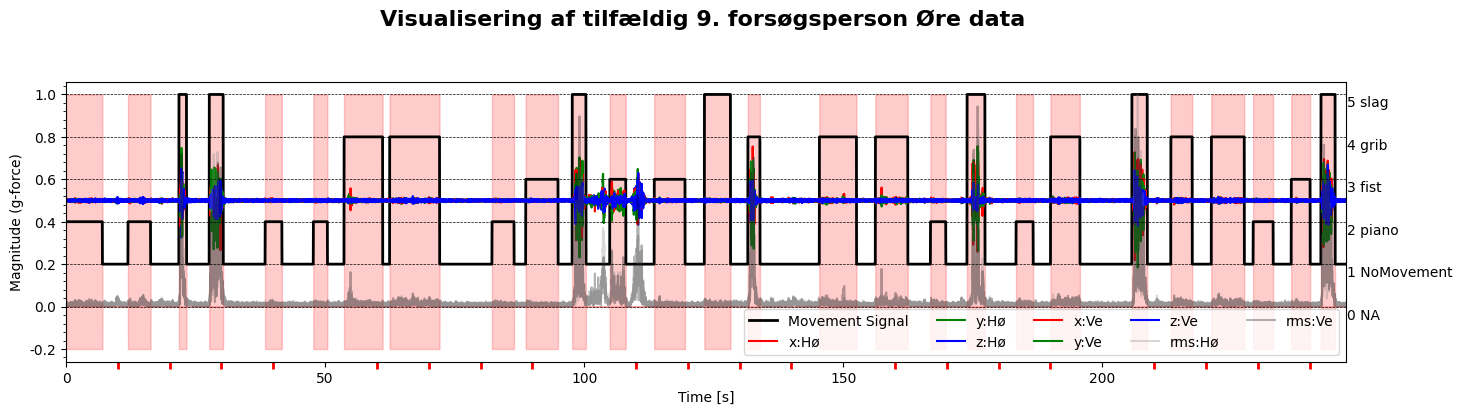

In [ ]:
#@title Plot data


start = timeline_s[0]
slut = timeline_s[-1]
# start = 260
# slut = 300



fig = plt.figure(figsize=[16,4])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                top=0.8, wspace=0.2,hspace=0.3)
fig.suptitle(f"Visualisering af {subjectName} {dataType} data ", fontsize= 16, fontweight="bold")

ax = plt.subplot(111)


m = np.zeros(len(moevment))
m[moevment>1] = 5
ax.fill_between(timeline_s ,m,color="r",alpha=0.2)
m[moevment>1] = -1
ax.fill_between(timeline_s ,m,color="r",alpha=0.2)


ax.plot(timeline_s,moevment,label='Movement Signal',color='black',linewidth=2)

color=['r','g','b','r','g','b',('grey', 0.3),('k', 0.3)]

scaleFactor = 5
for idx,id in enumerate(labels):
    ax.plot(timeline_s ,(data[id])*scaleFactor,label=id,color=color[idx])


for (val,name ) in enumerate(Movement):
    ax.axhline(y=val, color='k', linestyle='--',linewidth=0.5) #label=name ,
    t = (str(val) + " "+ name.name )
    ax.text(slut+0.2,val-0.3,(t),ha='left')


ax.legend(loc='lower right',ncol=5)


# ax.set_ylim((-1.5,6))
ax.set_xlim((start,slut))
# plt.xlim((31.5,33.5))

ax.minorticks_on()
ax.tick_params(axis='x',which='minor', length=5, color='r',width=2)


ax.set_xlabel("Time [s]")
ax.set_ylabel('Magnitude (g-force)')
ax.set_yticks([-1,0, 1, 2,3,4,5], [-1/scaleFactor,0/scaleFactor,1/scaleFactor,2/scaleFactor,3/scaleFactor,4/scaleFactor,5/scaleFactor])

plt.show()


In [ ]:
#@title segment_and_classify def

import pandas as pd
from numpy.fft import fft, ifft

def segment_and_classify(data,lable, window_size_s=1, overlap_s=0, fs=100):

   # Convert window size and overlap to samples
    window_samples = int(window_size_s * fs)
    overlap_samples = int(overlap_s * fs)

    segmented_data = []
    labled_data_dominate = []
    labled_data_samplewise = []
    segmented_fft = []


    for i in range(0, len(data) - window_samples + 1, window_samples - overlap_samples):
        segment = data[i:i + window_samples]
        samplewise = lable[i:i + window_samples]

        # Find the most frequent movement label within the segment
        dominant_movement = samplewise.mode()[0]  # Use iloc[0] to handle cases with multiple modes
        # print(samplewise)
        # print(dominant_movement)


        chs = (torch.transpose(segment, 0, 1))
        # display(chs.shape)

        fft_arr = np.zeros((chs.shape), dtype=np.complex128)
        # display(fft_arr.shape)

        for i, ch in enumerate(chs):
          # display(i)
          # display(ch.shape)
          # display(fft_arr[i].shape)
          f = fft(ch)
          f[0] = f[1]
          # display(f.shape)
          fft_arr[i] = f



        fft_tensor = torch.tensor(fft_arr, dtype=torch.complex128)

        segmented_data.append(chs)
        segmented_fft.append(fft_tensor)
        labled_data_dominate.append(dominant_movement)
        labled_data_samplewise.append(samplewise)




    segmented_data = np.array(segmented_data)
    segmented_data = torch.tensor(segmented_data, dtype=torch.float,requires_grad=True)

    segmented_fft = np.array(segmented_fft)
    segmented_fft = torch.tensor(segmented_fft, dtype=torch.complex128,requires_grad=True)


    labled_data_samplewise = np.array(labled_data_samplewise)
    labled_data_samplewise = torch.tensor(labled_data_samplewise, dtype=torch.long)

    labled_data_dominate = np.array(labled_data_dominate)
    labled_data_dominate = torch.tensor(labled_data_dominate, dtype=torch.long)


    return segmented_data,segmented_fft, labled_data_samplewise, labled_data_dominate



In [ ]:
#@title Segment and Classify excecute



raw_org_tensor = torch.tensor(raw_org, dtype=torch.float32)
label_org_tensor = torch.tensor(label_org, dtype=torch.long)

windowSize_Sec = 1.0
overlap_Sec = 0.0

segmented_data_tensor, segmented_fft_tensor,labled_data_samplewise_tensor, labled_data_dominate_tensor = segment_and_classify(raw_org_tensor,label_org_tensor,window_size_s=windowSize_Sec,overlap_s=overlap_Sec)




print((f'''
Dataset shapes:
    orginal rawda: {raw_org_tensor.shape}
    orginal label: {label_org_tensor.shape}

'''))


print((f'''
Dataset shapes:
    segmented_data: {segmented_data_tensor.shape}
      raw requires_grad: {segmented_data_tensor.requires_grad}
    segmented_fft:  {segmented_fft_tensor.shape}
      fft requires_grad: {segmented_fft_tensor.requires_grad}
    labled_data_samplewise: {labled_data_samplewise_tensor.shape}
    labled_data_dominate:   {labled_data_dominate_tensor.shape}
'''))




Dataset shapes:
    orginal rawda: torch.Size([24704, 8])
    orginal label: torch.Size([24704])



Dataset shapes:
    segmented_data: torch.Size([247, 8, 100])
      raw requires_grad: True
    segmented_fft:  torch.Size([247, 8, 100])
      fft requires_grad: True
    labled_data_samplewise: torch.Size([247, 100])
    labled_data_dominate:   torch.Size([247])



In [ ]:
#@title Import og def

from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent
from numpy.fft import fft, ifft

from torchsummary import summary

from collections import defaultdict

# Function to compute class distribution
def compute_distribution(targets, name):
    unique, counts = np.unique(targets, return_counts=True)
    percentages = (counts / len(targets)) * 100
    distribution_df = pd.DataFrame({
        "Value": unique,
        "Count": counts,
        "Percentage": percentages.round(1)
    })
    print(f"{name} Distribution:")
    print(distribution_df.to_string(index=False))
    print()
    return distribution_df




def split_balanced_data(data, targets, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,GetFirst=None):
    """
    Splits data into train, validation, and test sets with balanced class distribution.

    Parameters:
        data (tuple): A tuple of two arrays (raw_arr, fft_arr).
        targets (array-like): Array of class labels corresponding to `data`.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.

    Returns:
        dict: A dictionary containing train, val, and test splits for data and targets.
    """
    segmented_data_tensor, segmented_fft_tensor = data
    labled_data_dominate_tensor,labled_data_samplewise_tensor = targets

    if type(segmented_data_tensor) == torch.Tensor:
      raw_arr = segmented_data_tensor.detach().numpy()
      fft_arr = segmented_fft_tensor.detach().numpy()
      targets = labled_data_dominate_tensor.detach().numpy()
      target_samplewise = labled_data_samplewise_tensor.detach().numpy()
      print("Converted fra tensor til np.array")
    else:
      print("Var allrede np.array")
      raw_arr = segmented_data_tensor
      fft_arr = segmented_fft_tensor
      targets = labled_data_dominate_tensor
      target_samplewise = labled_data_samplewise_tensor


    assert len(raw_arr) == len(fft_arr) == len(targets), "Data and targets must have the same length."
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1."

    # Identify unique classes and their indices
    unique_classes, counts = np.unique(targets, return_counts=True)
    display(unique_classes)
    display(counts)
    print("BEfore here")


    class_indices = defaultdict(list)

    for idx, label in enumerate(targets):
    #   if len(class_indices[label])<GetFirst:
        class_indices[label].append(idx)


    # Shuffle indices for each class
    for label in unique_classes:
        np.random.shuffle(class_indices[label])




    # Shuffle indices for each class
    for label in unique_classes:
      if GetFirst == None:
        class_indices[label]  = class_indices[label]
      else:
        class_indices[label]  = class_indices[label][:GetFirst]


    train_indices, val_indices, test_indices = [], [], []

    for label in unique_classes:
        # display(f"label: {(label)}")

        # Determine split sizes for the current class
        n = len(class_indices[label])


        # display(f"label_n: {(n)}")
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        # Split indices for this class
        train_indices.extend(class_indices[label][:n_train])
        val_indices.extend(class_indices[label][n_train:n_train + n_val])
        test_indices.extend(class_indices[label][n_train + n_val:])



    train_indices.sort()
    val_indices.sort()
    test_indices.sort()



    display(f"train_indices: {len(train_indices)}")
    display(f"val_indices: {len(val_indices)}")
    display(f"test_indices: {len(test_indices)}")

    def get_split(indices):
      return {
        'data_raw': segmented_data_tensor[indices],
        'data_fft': segmented_fft_tensor[indices],
        'target_overall': labled_data_dominate_tensor[indices],
        'target_samplewise': labled_data_samplewise_tensor[indices],
        }



    train_data = get_split(train_indices)
    val_data = get_split(val_indices)
    test_data = get_split(test_indices)

    display(train_data.keys())

    # Compute and display distributions
    train_dist = compute_distribution(train_data['target_overall'], "Training Set")
    val_dist = compute_distribution(val_data['target_overall'], "Validation Set")
    test_dist = compute_distribution(test_data['target_overall'], "Test Set")

    train_data['dist'] = train_dist
    val_data['dist'] = val_dist
    test_data['dist'] = test_dist

    return {
        'train': train_data,
        'val': val_data,
        'test': test_data
    }


In [ ]:
#@title Split exceute
print((f'''
Dataset shapes:
    segmented_data: {segmented_data_tensor.shape}
      raw requires_grad: {segmented_data_tensor.requires_grad}
    segmented_fft: {segmented_fft_tensor.shape}
      fft requires_grad: {segmented_fft_tensor.requires_grad}
    labled_data_samplewise: {labled_data_samplewise_tensor.shape}
      samplewise requires_grad: {labled_data_samplewise_tensor.requires_grad}
    labled_data_dominate: {labled_data_dominate_tensor.shape}
      dominate requires_grad: {labled_data_dominate_tensor.requires_grad}

'''))




# Example Usage
np.random.seed(42)  # For reproducibility



splits = split_balanced_data((segmented_data_tensor, segmented_fft_tensor), (labled_data_dominate_tensor,labled_data_samplewise_tensor),
                             train_ratio=0.99,
                             val_ratio=0.01,
                             test_ratio=0.0,
                             GetFirst=None#400
                            #  GetFirst=1250 #of each class
                            #  GetFirst=400 #of each class
                             )


train = splits['train']
X_train = raw_org_tensor.detach().numpy()
y_train = label_org_tensor.detach().numpy()




from sklearn.linear_model import LinearRegression,LogisticRegression



Dataset shapes:
    segmented_data: torch.Size([247, 8, 100])
      raw requires_grad: True
    segmented_fft: torch.Size([247, 8, 100])
      fft requires_grad: True
    labled_data_samplewise: torch.Size([247, 100])
      samplewise requires_grad: False
    labled_data_dominate: torch.Size([247])
      dominate requires_grad: False


Converted fra tensor til np.array


array([1, 2, 3, 4, 5])

array([129,  32,  18,  49,  19])

BEfore here


'train_indices: 241'

'val_indices: 1'

'test_indices: 5'

dict_keys(['data_raw', 'data_fft', 'target_overall', 'target_samplewise'])

Training Set Distribution:
 Value  Count  Percentage
     1    127        52.7
     2     31        12.9
     3     17         7.1
     4     48        19.9
     5     18         7.5

Validation Set Distribution:
 Value  Count  Percentage
     1      1       100.0

Test Set Distribution:
 Value  Count  Percentage
     1      1        20.0
     2      1        20.0
     3      1        20.0
     4      1        20.0
     5      1        20.0



In [ ]:
#@title ShowStatsForModel def

def ShowStatsForModel(trues,pred,titelText=""):

  target_names=["NO","Piano","Fist","Grib","Punch"]

  # pred[pred==0] = 1
  cm = confusion_matrix(trues, pred)
  # print(cm)

  #report
  print(titelText)
  print(classification_report(trues, pred,target_names=target_names,labels=np.unique(trues) ,zero_division=0 ))
  # print(classification_report(trues, pred,labels=np.unique(trues) ,zero_division=0 ))


  target_names=["NO","Piano","Fist","Grib","Punch"]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
  # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f"confusion matrix for {titelText}:" )
  plt.show()



  cm = confusion_matrix(trues, pred,normalize="pred")
  # disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
  disp.plot()
  plt.title(f"normed confusion matrix for {titelText}" )
  plt.show()


In [ ]:
clfl = LogisticRegression(random_state=0).fit(X_train, y_train)


In [ ]:
#@title Make regression
from sklearn.linear_model import LinearRegression

def reassign(signal):
    signal[signal==5] = 5
    signal[signal==4] = 4
    signal[signal==3] = 3
    signal[signal==2] = 2
    signal[signal==1] = 1
    return signal

true = reassign(y_train.copy())
clf = LinearRegression().fit(X_train,true )

pred = clf.predict(X_train[:2, :])
# probs = clf.predict_proba(X_train[:2, :])


# score = clf.score(X_train, y_train)

print(pred)
# print(probs)
# print(score)


[2.0996382 2.0949805]


mse: 1.8381087835448586
rmse: 1.3557687057698518


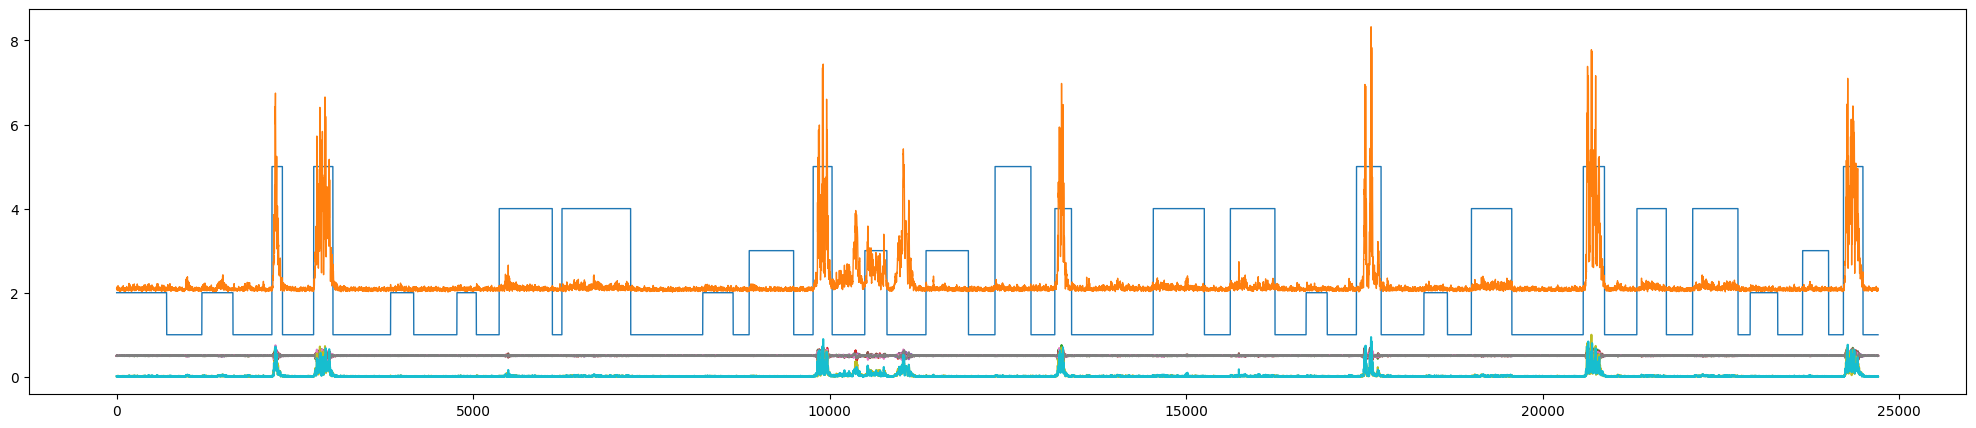

In [ ]:
# %% RMSE - Root mean squre error
true = reassign(y_train.copy())

pred = clf.predict(X_train)

predRe = (pred.copy())
# predRe = reassign(pred.copy())
trueRe = (true.copy())
# trueRe = reassign(true.copy())

from sklearn.metrics import mean_squared_error, cohen_kappa_score
from math import sqrt

mse = mean_squared_error(trueRe,predRe)
rmse = sqrt(mean_squared_error(trueRe, predRe))
print(f"mse: {mse}")
print(f"rmse: {rmse}")


plt.figure(figsize=(25,5))
plt.plot(trueRe,linewidth=1)
plt.plot(predRe,linewidth=1)
plt.plot(X_train)
# plt.plot(predRe+rmse)
# plt.plot(predRe-rmse)
# plt.xlim((50000,60000))

plt.show()




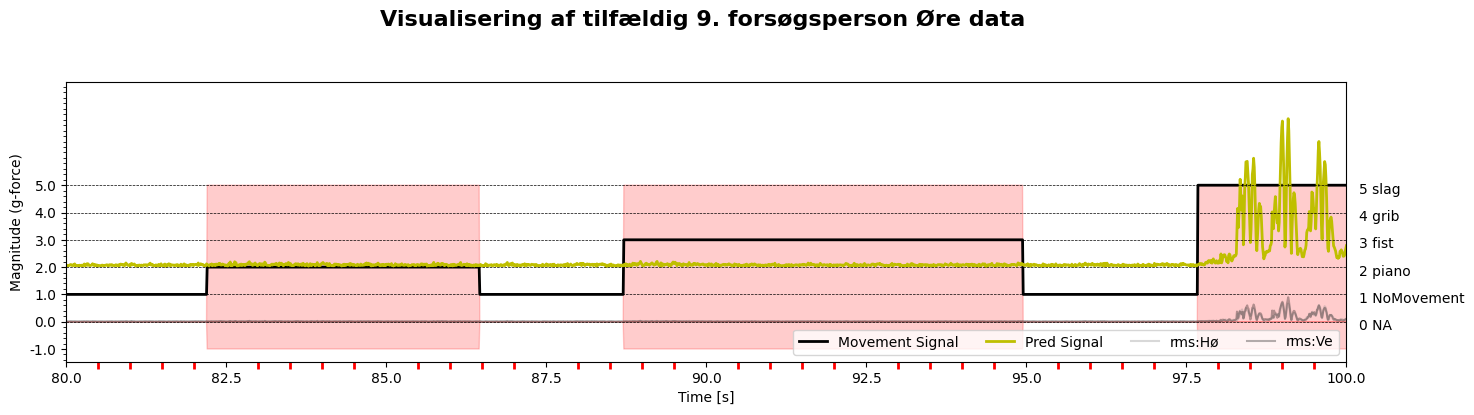

In [ ]:

start = timeline_s[0]
slut = timeline_s[-1]
# start = 1200
# slut = 1250

# start = 360
# slut = 420

# start = 530
# slut = 580

start = 80
slut = 100



fig = plt.figure(figsize=[16,4])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                top=0.8, wspace=0.2,hspace=0.3)
fig.suptitle(f"Visualisering af {subjectName} {dataType} data ", fontsize= 16, fontweight="bold")

ax = plt.subplot(111)


m = np.zeros(len(moevment))
m[moevment>1] = 5
ax.fill_between(timeline_s ,m,color="r",alpha=0.2)
m[moevment>1] = -1
ax.fill_between(timeline_s ,m,color="r",alpha=0.2)


ax.plot(timeline_s,trueRe,label='Movement Signal',color='black',linewidth=2)
ax.plot(timeline_s,predRe,label='Pred Signal',color='y',linewidth=2)

color=['r','g','b','r','g','b',('grey', 0.3),('k', 0.3)]

scaleFactor = 1
for idx,id in enumerate(labels):
    if idx >=6:
      ax.plot(timeline_s ,(data[id])*scaleFactor,label=id,color=color[idx])


for (val,name ) in enumerate(Movement):
    ax.axhline(y=val, color='k', linestyle='--',linewidth=0.5) #label=name ,
    t = (str(val) + " "+ name.name )
    ax.text(slut+0.2,val-0.3,(t),ha='left')


ax.legend(loc='lower right',ncol=5)


# ax.set_ylim((-1.5,6))
ax.set_xlim((start,slut))
# plt.xlim((31.5,33.5))

ax.minorticks_on()
ax.tick_params(axis='x',which='minor', length=5, color='r',width=2)


ax.set_xlabel("Time [s]")
ax.set_ylabel('Magnitude (g-force)')
ax.set_yticks([-1,0, 1, 2,3,4,5], [-1/scaleFactor,0/scaleFactor,1/scaleFactor,2/scaleFactor,3/scaleFactor,4/scaleFactor,5/scaleFactor])

plt.show()

tilfældig 9. forsøgsperson - Øre
              precision    recall  f1-score   support

          NO       0.53      0.98      0.69     12632
       Piano       0.00      0.00      0.00      3171
        Fist       0.00      0.00      0.00      1894
        Grib       0.04      0.00      0.00      4902
       Punch       0.75      0.39      0.51      2105

    accuracy                           0.54     24704
   macro avg       0.26      0.28      0.24     24704
weighted avg       0.34      0.54      0.40     24704



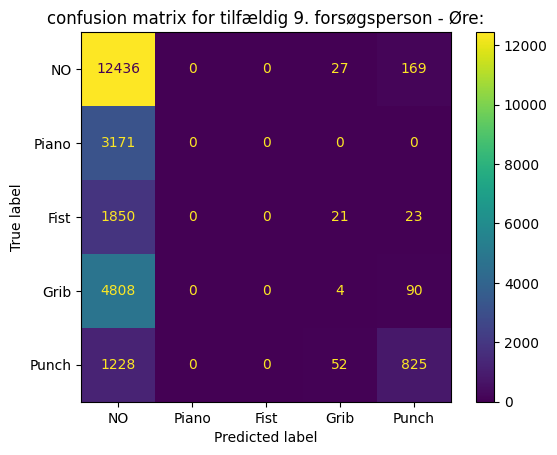

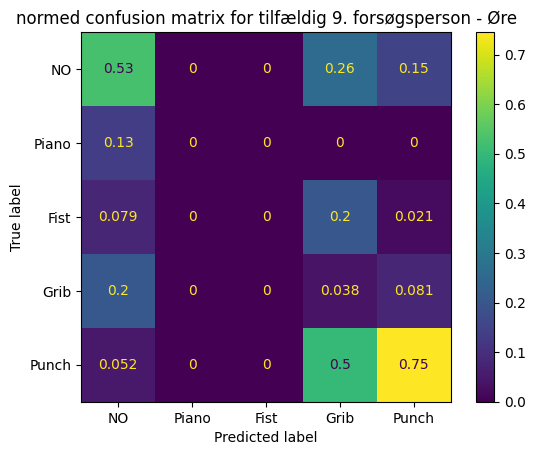

In [ ]:
#@title CM for Train
y_pred_train = clfl.predict(X_train)
ShowStatsForModel(y_train,y_pred_train,titelText=plottext)



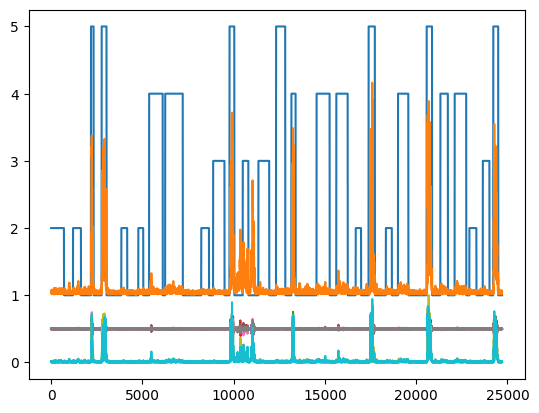

In [ ]:
#@title plot for train
plt.figure()
plt.plot(y_train)
plt.plot(pred/2)
plt.plot(X_train)
# plt.xlim((15000,25000))
plt.show()

In [ ]:
#@title pred og cm for test
pred = clf.predict(X_train[:2, :])
probs = clf.predict_proba(X_train[:2, :])
score = clf.score(X_train, y_train)

print(pred)
print(probs)
print(score)

y_pred_train = clf.predict(X_train)
ShowStatsForModel(y_train,y_pred_train,titelText=plottext)


AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [ ]:
#@title plot for test
plt.figure()
plt.plot(y_train)
plt.plot(y_pred_train)
plt.plot(X_train)
# plt.xlim((15000,25000))
plt.show()



In [ ]:

# print(ModelName)
# print(name)
print()




trueRe = y_train
y_predRe = y_pred_train
# p_value = pred


print("y_pred without overlap")


print(f"RMSE \t: {np.round(sqrt(mean_squared_error(trueRe, y_predRe)),3)}")

# results.append(metrics)


for i in [1,2,3,4,5]:
  idx = trueRe==i
  t_value = trueRe[idx]
  p_value = y_predRe[idx]

  # print(t_value)
  # print(p_value)

  rmse = sqrt(mean_squared_error(t_value, p_value))
  print(f"RMSE for {i}: {np.round(rmse,3)}")




trueRe = y_train
y_predRe = y_pred_train



y_pred without overlap
RMSE 	: 1.762
RMSE for 1: 0.483
RMSE for 2: 1.0
RMSE for 3: 1.992
RMSE for 4: 2.974
RMSE for 5: 3.059


In [ ]:
def CalcKappa(true,pred,kappamap=[1,2,3,4,5],kappename=""):


  print(kappename)
  def reassign(signal):
      signal[signal==1] = kappamap[0]
      signal[signal==2] = kappamap[1]
      signal[signal==3] = kappamap[2]
      signal[signal==4] = kappamap[3]
      signal[signal==5] = kappamap[4]
      return signal

  print(kappamap)
  trueRe = reassign(true.copy())
  predRe = reassign(pred.copy())

  kappa_pred = cohen_kappa_score(trueRe,predRe)
  print(f"pred kappa: \t\t{np.round(kappa_pred,3)}")



print()


trueRe = y_train
y_predRe = y_pred_train


kappamap = [1,2,3,4,5]
CalcKappa(trueRe.copy(),y_predRe.copy(),kappamap,kappename = "5x5")
kappamap = [1,1,1,4,5]
CalcKappa(trueRe.copy(),y_predRe.copy(),kappamap,kappename = "3x3")
kappamap = [1,1,1,5,5]
CalcKappa(trueRe.copy(),y_predRe.copy(),kappamap,kappename = "2x2")



5x5
[1, 2, 3, 4, 5]
pred kappa: 		0.09
3x3
[1, 1, 1, 4, 5]
pred kappa: 		0.173
2x2
[1, 1, 1, 5, 5]
pred kappa: 		0.167
